## Setup and Imports

In [110]:
import sys
sys.path.append("/ML_CW2/TorchSSL")  

import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import json

from torch.utils.data import DataLoader, Subset, Dataset, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR

# For clustering & neighbors
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

from resnet_cifar import resnet18

In [111]:
def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Load CIFAR-10 Dataset

 use random crop + horizontal flip + normalization for training augmentation, as recommended by Hacohen et al. (2022) in their fully supervised setting.

In [112]:
set_seed(42) 

# Download CIFAR-10
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=None  # returns PIL images
)

# Basic test transform (no random crop/flip for test data)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=test_transform
)

testloader = DataLoader(testset, batch_size=256, shuffle=False)


## Define Models
# 
# 
##### - `create_resnet18_for_cifar` for a ResNet-18 classifier
##### - `SimCLRNet` for loading a pre-trained SimCLR backbone
##### - `LinearClassifier` for linear evaluation on embeddings

In [113]:
def create_resnet18_for_cifar(num_classes=10):
    """
    Returns a ResNet-18 backbone 
    plus a final linear layer for classification.
    """
    backbone_dict = resnet18(in_channel=3)  
    backbone = backbone_dict['backbone']
    feature_dim = backbone_dict['dim']  # 512

    class ResNet18Classifier(nn.Module):
        def __init__(self):
            super().__init__()
            self.backbone = backbone
            self.fc = nn.Linear(feature_dim, num_classes)

        def forward(self, x, return_features=False):
            feats = self.backbone(x)  # shape [bs, 512]
            logits = self.fc(feats)   # shape [bs, num_classes]
            if return_features:
                return logits, feats
            else:
                return logits

    return ResNet18Classifier()



In [136]:
#from resnet_cifar import resnet18

class SimCLRNet(nn.Module):
    """
    A ResNet-18 backbone plus a contrastive head for pre-trained SimCLR.
    use for self-supervised embeddings.
    """
    def __init__(self):
        super().__init__()
        backbone_dict = resnet18(in_channel=3)
        self.backbone = backbone_dict['backbone']   
        backbone_dim  = backbone_dict['dim']       
        #print("backbone done")

        self.contrastive_head = nn.Sequential(
            nn.Linear(backbone_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 128)

        )

    def forward(self, x, return_features=False):
        feats = self.backbone(x)          
        proj  = self.contrastive_head(feats) 
        if return_features:
            return proj, feats
        else:
            return proj


# Instantiate model
#simclr_model = SimCLRNet ()  #features_dim=128

# Load  Pretrained SimCLR Model
checkpoint_path = 'simclr_cifar-10.pth/simclr_cifar-10.pth'
checkpoint = torch.load(checkpoint_path, map_location='cpu')
new_state_dict = {}

for key, value in checkpoint.items():
    #  rename "encoder." -> "backbone."
    if key.startswith("encoder."):
        new_key = "backbone." + key[len("encoder."):]
    #  rename "projector." -> "contrastive_head."
    elif key.startswith("projector."):
        new_key = "contrastive_head." + key[len("projector."):]
    else:
        new_key = key

    
    new_state_dict[new_key] = value

simclr_model = SimCLRNet()
simclr_model.load_state_dict(new_state_dict, strict=False)
simclr_model.eval()

#print(new_state_dict )
#print(simclr_model.load_state_dict(new_state_dict))

SimCLRNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [115]:
import torch
import torch.nn as nn

class LinearClassifier(nn.Module):
    """
    For linear evaluation on extracted embeddings.
    """
    def __init__(self, embed_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        
        return self.linear(x)


## 4. Helper Functions
# 
#### This section includes:
##### - `extract_embeddings` for turning a subset of data into embedding vectors  
##### - `cluster_embeddings`, `compute_typicality_sklearn`, `select_typical_samples` for TPC(RP)  
##### - `query_selection` for the main AL selection logic  
##### - `evaluate` for evaluating a classifier


In [116]:
class TransformedSubset(Dataset):
    """
    A custom subset that can apply transforms on the fly.
    """
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.base_dataset[real_idx]
        if self.transform is not None:
            img = self.transform(img)  
        return img, label

    def __len__(self):
        return len(self.indices)


def extract_embeddings(model, dataset, device='cpu', batch_size=256):
    """
    Convert PIL -> Tensor before passing to model.
    No random augmentations here, only basic normalization.
    """
    from torch.utils.data import DataLoader

    embedding_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.4914, 0.4822, 0.4465],
                             [0.2470, 0.2435, 0.2616])
    ])

    indices = list(range(len(dataset)))

    transformed_subset = TransformedSubset(
        base_dataset=dataset,
        indices=indices,
        transform=embedding_transform
    )

    loader = DataLoader(transformed_subset, batch_size=batch_size, shuffle=False)

    all_feats = []
    model.to(device)
    model.eval()

    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            # forward pass
            _, feats = model(imgs, return_features=True)
            all_feats.append(feats.cpu().numpy())

    return np.concatenate(all_feats, axis=0)


This is the modification implemented, uses gaussians density Rather than calculating typicality using the inverse distance. It this smoothes out outliers and help focus more on most dense regions.
Use this function in place of compute_typicality_sklearn, when trying to test the modified version.

In [117]:


def compute_gaussian_density(embeddings, k=20, alpha=0.2):
    """
    Computes a Gaussian-based density score for each point.
    For each point, we find its k nearest neighbors and
    sum exp(-alpha * d^2) for their distances d.

    Args:
      embeddings (np.ndarray): shape [N, D], N points in D-dim space
      k (int): number of neighbors to consider
      alpha (float): kernel width parameter

    Returns:
      scores (np.ndarray): shape [N], density score per point
    """
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    # Distances: shape [N, k+1], indices: shape [N, k+1]
    dist, _ = nbrs.kneighbors(embeddings)
    
    
    # sum over neighbors 1..k
    dist_to_neighbors = dist[:, 1:]  # shape [N, k]

    # Gaussian kernel weights: exp(-alpha * d^2)
    # shape [N, k]
    weights = np.exp(-alpha * (dist_to_neighbors ** 2))

    # sum across the k neighbors for each point
    scores = weights.sum(axis=1)

    return scores


In [118]:

def cluster_embeddings(embeddings, n_clusters):
    """
    Runs K-means clustering on the embeddings, returning cluster labels.
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    unique_clusters, counts = np.unique(cluster_labels, return_counts=True)
    print("Cluster distribution:", dict(zip(unique_clusters, counts)))

    return cluster_labels


In [119]:


def compute_typicality_sklearn(embeddings, k=20):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    dist, _ = nbrs.kneighbors(embeddings)
    avg_dist = dist[:, 1:].mean(axis=1)
    return 1.0 / (avg_dist + 1e-8)
#typicality_vals = compute_typicality_sklearn(embeddings, k=20)

In [120]:
def select_typical_samples(embeddings, cluster_labels, B, typicality_vals):
    """
    In each cluster, pick the point with the highest typicality.
    """
    chosen_indices = []
    for cluster_id in range(B):
        cluster_idx = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_idx) == 0:
            continue
        cluster_tvals = typicality_vals[cluster_idx]
        best_local_idx = cluster_idx[np.argmax(cluster_tvals)]
        chosen_indices.append(best_local_idx)
    return chosen_indices


The select_typical_samples2 is the modified method of selecting typical samples. replace with select_typical_samples when trying to run the modified version

In [121]:
def select_typical_samples2(embeddings, cluster_labels, B,scores):
    chosen_indices = []
    for cluster_id in range(B):
        cluster_idx = np.where(cluster_labels == cluster_id)[0]
        if len(cluster_idx) == 0:
            continue
        best_local_idx = cluster_idx[np.argmax(scores[cluster_idx])]
        chosen_indices.append(best_local_idx)
    return chosen_indices



To enable the modified TPC(RP): comment out the lines using `typicality_vals` and `best_idx = max(candidates, key=lambda g_idx: typicality_vals[idx2row[g_idx]])` then uncomment the lines using `scores = compute_gaussian_density(...)` and `best_idx = max(candidates, key=lambda g_idx: scores[idx2row[g_idx]])`

Hence: # Uncomment the following two lines to use the Gaussian-based density measure:

- #scores = compute_gaussian_density(all_embeddings, k=k_neighbors, alpha=0.2)
- #Then, replace the selection line below with the one using `scores`


In [ ]:
import numpy as np
from collections import Counter

def typical_clust_query(
    dataset,
    labeled_indices,
    unlabeled_indices,
    B,
    feature_extractor,     # simclr_model or a fully supervised model
    device='cpu',
    k_neighbors=20
):
    """
    Implements the key logic of TypiClust as described in the paper:
      1) Compute embeddings for all data (labeled + unlabeled).
      2) Cluster entire dataset into (|L| + B) clusters.
      3) Determine which clusters are covered (i.e., contain labeled points).
      4) From uncovered clusters, pick the single most typical unlabeled point.
         Continue until collect B new unlabeled points.

    :param dataset:            Full CIFAR-10 dataset (trainset).
    :param labeled_indices:    Current list of labeled indices L_{i-1}.
    :param unlabeled_indices:  Current list of unlabeled indices U_{i-1}.
    :param B:                  Number of points to query.
    :param feature_extractor:  Model to produce embeddings (e.g., simclr_model).
    :param device:             'cpu' .
    :param k_neighbors:        Number of neighbors used in typicality computation.

    :return: chosen_indices    The B newly selected unlabeled indices.
    """
    # Step 1: Extract embeddings
    
    # Embed all data to see which clusters contain labeled points.
    all_indices = labeled_indices + unlabeled_indices
    all_embeddings = extract_embeddings(feature_extractor,
                                        Subset(dataset, all_indices),
                                        device=device,
                                        batch_size=256)
    # all_embeddings will be aligned with all_indices in order

    # Make a map from global_idx to row_in_all_embeddings
    # row_in_all_embeddings = position of the data in all_indices
    idx2row = {g_idx: row for row, g_idx in enumerate(all_indices)}

    # Step 2: K-Means Clustering

    num_clusters = len(labeled_indices) + B
    cluster_labels = cluster_embeddings(all_embeddings, n_clusters=num_clusters)
    # cluster_labels[i] is the cluster ID for all_embeddings[i]

    # Step 3: Covered vs. Uncovered
    # A cluster is "covered" if it contains at least one labeled point.
    covered_clusters = set()
    for g_idx in labeled_indices:
        row = idx2row[g_idx]                 # find which row in all_embeddings
        c_id = cluster_labels[row]           # cluster ID
        covered_clusters.add(c_id)

    # Build a map cluster_id -> list of unlabeled global indices in that cluster
    cluster_to_unlabeled = {}
    for g_idx in unlabeled_indices:
        row = idx2row[g_idx]
        c_id = cluster_labels[row]
        if c_id not in cluster_to_unlabeled:
            cluster_to_unlabeled[c_id] = []
        cluster_to_unlabeled[c_id].append(g_idx)

    # Step 4: Pick from uncovered clusters
    # Only consider clusters that do NOT appear in covered_clusters
    # and that have at least one unlabeled point.
    uncovered_clusters = []
    for c_id, unl_idxs in cluster_to_unlabeled.items():
        if c_id not in covered_clusters and len(unl_idxs) > 0:
            uncovered_clusters.append(c_id)

    # If there are more uncovered clusters than B, pick the B largest uncovered clusters
    # (largest = cluster with the most unlabeled points)
    cluster_sizes = [(c_id, len(cluster_to_unlabeled[c_id])) for c_id in uncovered_clusters]
    cluster_sizes.sort(key=lambda x: x[1], reverse=True)  # sort by cluster size descending
    selected_clusters = [c_id for (c_id, _) in cluster_sizes[:B]]

    # Step 5: Within each selected cluster, pick the most typical unlabeled sample
    
    chosen_indices = []
    if len(selected_clusters) == 0:
        # fallback: if everything is covered, pick random
        return list(np.random.choice(unlabeled_indices, size=B, replace=False))

    # Precompute typicality for *all* embeddings
    # Then pick typical points among unlabeled subset
    
    typicality_vals = compute_typicality_sklearn(all_embeddings, k=k_neighbors)         # comment out when using modified version

    #scores = compute_gaussian_density(all_embeddings, k=k_neighbors, alpha=0.2)     # Uncomment to use modified version


    for c_id in selected_clusters:
        # unlabeled points in cluster c_id
        candidates = cluster_to_unlabeled[c_id]
        if len(candidates) == 0:
            continue
        # pick the candidate with highest typicality
        best_idx = max(candidates, key=lambda g_idx: typicality_vals[idx2row[g_idx]])    # comment out when usind modified version
        
        #best_idx = max(candidates, key=lambda g_idx: scores[idx2row[g_idx]])           # Uncomment to use modified version
        chosen_indices.append(best_idx)

    # If fewer than B were chosen (e.g. fewer uncovered clusters),
    # pick more from random or any fallback strategy:
    if len(chosen_indices) < B:
        needed = B - len(chosen_indices)
        # pick from the unlabeled set that wasn't chosen yet
        leftover_unlabeled = list(set(unlabeled_indices) - set(chosen_indices))
        extra = np.random.choice(leftover_unlabeled, size=needed, replace=False)
        chosen_indices.extend(extra)

    return chosen_indices


In [123]:
def query_selection(
    selection_mode,     
    embedding_mode,      
    unlabeled_indices,
    dataset,
    device='cpu',
    classifier=None,
    simclr_model=None,
    B=10,
    labeled_indices=None   
):
    if selection_mode == 'random':
        return list(np.random.choice(unlabeled_indices, size=B, replace=False))

    elif selection_mode == 'tpcrp':
        # Call the typical_clust_query function
        chosen_global = typical_clust_query(
            dataset=dataset,
            labeled_indices=labeled_indices,
            unlabeled_indices=unlabeled_indices,
            B=B,
            feature_extractor=(simclr_model if embedding_mode == 'selfsupervised' else classifier),
            device=device,
            k_neighbors=20
        )
        return chosen_global

    else:
        raise ValueError(f"Unknown selection_mode: {selection_mode}")


In [124]:
def evaluate(model, test_loader, device='cpu'):
    """
    Evaluates model accuracy on the test set.
    """
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs).argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return 100.0 * correct / total

In [125]:
def train_linear_on_embeddings(
    simclr_model,       # Pretrained self-supervised model
    dataset,            # Full dataset (CIFAR-10)
    labeled_indices,    # Indices of labeled data
    embed_dim=512,      
    num_classes=10,
    epochs=100,
    lr= 2.5, 
    batch_size=64,
    device='cpu'
):
    # Build a subset of the labeled data
    labeled_subset = Subset(dataset, labeled_indices)
    labels = [dataset.targets[i] for i in labeled_indices]

    # Extract embeddings for labeled data
    embeddings = extract_embeddings(simclr_model, labeled_subset, device=device, batch_size=batch_size)
    embeddings_tensor = torch.from_numpy(embeddings).float()
    labels_tensor = torch.tensor(labels, dtype=torch.long)

    # Create a TensorDataset for easy DataLoader usage
    labeled_dataset_embed = TensorDataset(embeddings_tensor, labels_tensor)
    loader = DataLoader(labeled_dataset_embed, batch_size=batch_size, shuffle=True)

    # Create a linear classifier
    linear_clf = LinearClassifier(embed_dim, num_classes).to(device)

    # Setup optimizer and loss
    optimizer = torch.optim.SGD(linear_clf.parameters(), lr=lr, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    # Training loop
    linear_clf.train()
    for ep in range(epochs):
        for x_batch, y_batch in loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            logits = linear_clf(x_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

    return linear_clf


 ### Evaluate Linear Classifier on Self-Supervised Embeddings

In [126]:
def evaluate_linear_on_embeddings(
    simclr_model,
    linear_clf,
    testset,
    batch_size=256,
    device='cpu'
):
    """
    Evaluates the performance of a linear classifier trained on self-supervised embeddings.

    Args:
      simclr_model: the pre-trained SimCLR model used for feature extraction
      linear_clf: a linear layer (classifier) trained on extracted embeddings
      testset: the test dataset (with transforms already applied if needed)
      batch_size: how many samples per batch during evaluation
      device: "cpu" 

    Returns:
      accuracy (%): the top-1 classification accuracy on the testset
    """
    test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)
    correct, total = 0, 0

    
    simclr_model.eval()
    linear_clf.eval()

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Extract features from simCLR model
            _, feats = simclr_model(imgs, return_features=True)

            # Classify these features using the linear layer
            logits = linear_clf(feats)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return 100.0 * correct / total


### Fully Supervised (Paper-Style) Training
# 
#### This function implements the training procedure described in the paper:
##### - SGD with momentum=0.9, Nesterov=True
##### - Cosine LR scheduler
##### - Random crop + horizontal flip for augmentation

In [127]:

import torch.optim as optim

def train_fully_supervised(
    model,
    dataset,
    labeled_indices,
    device='cpu',
    epochs=100,
    initial_lr=0.025,
    batch_size=64
):
    """
    Args:
      model: the neural network model to train
      dataset: the entire training dataset (unlabeled + labeled), from which labeled_indices is picked
      labeled_indices: which samples to use for supervised training
      device: "cpu" 
      epochs: total number of epochs to train
      initial_lr: the initial learning rate for SGD
      batch_size: mini-batch size

    Returns:
      model: the trained model after the specified epochs
    """
    # Augmentations: random crop and horizontal flip
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616]
        )
    ])
    
    # Create a small dataset that applies these transforms only to the labeled subset
    class LabeledDatasetWithAug(torch.utils.data.Dataset):
        def __init__(self, base_dataset, indices):
            self.base_dataset = base_dataset
            self.indices = indices
            self.transform = train_transform

        def __getitem__(self, idx):
            real_idx = self.indices[idx]
            img, label = self.base_dataset[real_idx]
            # Apply augmentations
            img = self.transform(img)
            return img, label

        def __len__(self):
            return len(self.indices)

    labeled_dataset_aug = LabeledDatasetWithAug(dataset, labeled_indices)
    loader = DataLoader(labeled_dataset_aug, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=initial_lr,
        momentum=0.9,
        nesterov=True
    )
    # CosineAnnealingLR cycles the LR down to 0 over 'epochs' steps
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    model.to(device)
    model.train()

    for ep in range(epochs):
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Step the LR scheduler after each epoch
        scheduler.step()
    
    return model


### Unlabeled Dataset (Weak & Strong Augmentations)
# 
#### For semi-supervised training, two augmentations are needed:
##### - Weak: e.g., random crop + flip
##### - Strong: e.g., extra color jitter


In [128]:
class UnlabeledDatasetWeakStrong(Dataset):
    """
    For unlabeled data, (x_weak, x_strong).
    
    Args:
      base_dataset: a dataset of unlabeled samples
      transform_weak: a transform for 'weak' augmentation
      transform_strong: a transform for 'strong' augmentation
    """
    def __init__(self, base_dataset, transform_weak, transform_strong):
        self.base_dataset = base_dataset
        self.transform_weak = transform_weak
        self.transform_strong = transform_strong

    def __getitem__(self, idx):
        img, _ = self.base_dataset[idx]
        x_weak = self.transform_weak(img)
        x_strong = self.transform_strong(img)
        return x_weak, x_strong

    def __len__(self):
        return len(self.base_dataset)


### Labeled Dataset Wrapper
# 
##### `LabeledDataset` is similar, but each sample includes its real label. 

In [129]:
from torch.utils.data import Dataset
class LabeledDataset(Dataset):
    """
    A small wrapper to handle labeled subsets with optional transforms.
    """
    def __init__(self, base_dataset, indices, transform=None):
        self.base_dataset = base_dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        img, label = self.base_dataset[real_idx]  
        if self.transform is not None:
            img = self.transform(img)  
        return img, label

    def __len__(self):
        return len(self.indices)


### Augmentation Pipelines
# 
##### - `labeled_transform`: random crop + flip + normalize for the labeled set
##### - `weak_transform`: a milder augmentation
##### - `strong_transform`: includes additional color jitter


In [130]:
labeled_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])
#import torchvision.transforms as transforms

weak_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])

strong_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.4, contrast=0.4,
                           saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465],
                         [0.2470, 0.2435, 0.2616])
])


In [131]:
import torch.nn.functional as F
import torch

def train_semisupervised_weak_strong(
    model,
    labeled_dataset,        
    unlabeled_weak_strong,  
    device='cpu',
    epochs=50,
    batch_size=64,
    lr=1e-3,
    unsup_weight=1.0,
    conf_threshold=0.70
):
    labeled_loader   = DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)
    unlabeled_loader = DataLoader(unlabeled_weak_strong, batch_size=batch_size, shuffle=True)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    model.to(device)
    model.train()

    steps_per_epoch = min(len(labeled_loader), len(unlabeled_loader))

    for epoch in range(epochs):
        labeled_iter   = iter(labeled_loader)
        unlabeled_iter = iter(unlabeled_loader)

        for step in range(steps_per_epoch):
            # 1) Labeled batch
            x_l, y_l = next(labeled_iter, (None, None))
            x_l, y_l = x_l.to(device), y_l.to(device)

            # 2) Unlabeled batch => (x_weak, x_strong)
            x_weak, x_strong = next(unlabeled_iter, (None, None))
            x_weak, x_strong = x_weak.to(device), x_strong.to(device)

            # -- Forward pass on labeled batch
            logits_l = model(x_l)
            sup_loss = criterion(logits_l, y_l)

            # -- Forward pass on weakly augmented unlabeled
            with torch.no_grad():
                logits_weak = model(x_weak)
                probs_weak = F.softmax(logits_weak, dim=1)
                max_probs, pseudo_labels = probs_weak.max(dim=1)

            # Confidence mask
            mask = (max_probs >= conf_threshold).float()

            # -- Forward pass on strongly augmented unlabeled
            logits_strong = model(x_strong)
            unsup_loss = criterion(logits_strong, pseudo_labels)
            unsup_loss = (unsup_loss * mask).mean()

            # Combine
            loss = sup_loss + unsup_weight * unsup_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model


### Active Learning Loop (Fully Supervised)
# 
#### This loop repeatedly:
##### 1) Trains a fresh model from scratch on the labeled set (paper-style).
##### 2) Evaluates on the test set.
##### 3) Queries the next B samples (random or TPC(RP)).


In [132]:
def active_learning_loop_fully_supervised(
    trainset,
    testloader,
    selection_mode,   #"random" or "tpcrp"
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
):
    """
    Each cycle:
      1) Pick new labeled samples (random or TPC(RP)).
      2) Train a fresh ResNet18 fully supervised.
      3) Evaluate.
    """
    unlabeled_indices = list(range(len(trainset)))
    labeled_indices   = []

    # Initial pick is random
    init_selection = query_selection("random", None, unlabeled_indices, trainset, B=initial_B)
    for idx in init_selection:
        unlabeled_indices.remove(idx)
        labeled_indices.append(idx)

    accuracies = []

    for cycle in range(cycles):
        print(f"\n=== FullySupervised Cycle {cycle}, #Labeled={len(labeled_indices)} ===")

        # Train a fresh model as directed by the paper
        model = create_resnet18_for_cifar(num_classes=10)
        model = train_fully_supervised(
            model,
            dataset=trainset,
            labeled_indices=labeled_indices,
            device=device,
            epochs=100,
            initial_lr=0.025,
            batch_size=64
        )

        # Evaluate
        acc = evaluate(model, testloader, device=device)
        print(f"Cycle {cycle} Accuracy: {acc:.2f}%")
        accuracies.append(acc)

        # Query new B
        
        new_selection = query_selection(
            selection_mode,
            embedding_mode="fullysupervised",  # or "fullysupervised"
            unlabeled_indices=unlabeled_indices,
            dataset=trainset,
            device=device,
            classifier=model,  
            #simclr_model=simclr_model,
            B=cycle_B,
            labeled_indices=labeled_indices  # <-- Important
            )


        for idx in new_selection:
            unlabeled_indices.remove(idx)
            labeled_indices.append(idx)

    return accuracies


### Active Learning Loop: Self-Supervised
# 
#### The function below implements a self-supervised active learning loop.
##### 1. `simclr_model` to embed unlabeled samples, and then pick points using TPC(RP) or random selection.
##### 2. After labeling those points, we train a linear classifier (`train_linear_on_embeddings`) on top of the SimCLR embeddings.
##### 3. We evaluate the linear classifier with `evaluate_linear_on_embeddings`.
##### 4. repeat for multiple cycles.

In [133]:
def active_learning_loop_self_supervised(
    trainset,
    testloader,
    selection_mode,
    simclr_model,    # pre-trained SimCLR model
    initial_B=10,
    cycle_B=10,
    cycles=5,
    device='cpu'
):
    """
    1) Use simclr_model for TPC(RP) queries.
    2) Train a fresh ResNet18Classifier on the labeled set.
    3) Evaluate each cycle.
    """

    # Unlabeled pool initially includes all training indices
    unlabeled_indices = list(range(len(trainset)))
    labeled_indices   = []

    # Initial pick using TPC(RP) + selfsupervised
    init_selection = query_selection(
        selection_mode,
        "selfsupervised",
        unlabeled_indices,
        trainset,
        device=device,
        simclr_model=simclr_model,
        B=initial_B,
        labeled_indices=labeled_indices
    )

    # Move them from unlabeled to labeled
    for idx in init_selection:
        unlabeled_indices.remove(idx)
        labeled_indices.append(idx)

    accuracies = []

    # Active Learning cycles
    for cycle in range(cycles):
        print(f"\n=== SelfSupervised AL Cycle {cycle}, #Labeled={len(labeled_indices)} ===")

        # Train a linear classifier on the embeddings of the labeled set
        linear_clf = train_linear_on_embeddings(
            simclr_model=simclr_model,
            dataset=trainset,
            labeled_indices=labeled_indices,
            embed_dim=512,   
            num_classes=10,
            epochs=100,
            lr= 2.5, 
            batch_size=64,
            device='cpu'
        )

        # Evaluate the linear classifier
        acc = evaluate_linear_on_embeddings(
            simclr_model=simclr_model,
            linear_clf=linear_clf,
            testset=testset,
            batch_size=64,
            device='cpu'
        )
        print(f"Test Accuracy: {acc:.2f}%")
        accuracies.append(acc)

        # Acquire more labels
        # Next selection using simclr_model
        
        new_selection = query_selection(
            selection_mode,
            embedding_mode="selfsupervised",  # or "fullysupervised"
            unlabeled_indices=unlabeled_indices,
            dataset=trainset,
            device=device,
            #classifier=model,  # or simclr_model, depending on your approach
            simclr_model=simclr_model,
            B=cycle_B,
            labeled_indices=labeled_indices  # <-- Important
            )
        for idx in new_selection:
            unlabeled_indices.remove(idx)
            labeled_indices.append(idx)

    return accuracies

### Class-Balanced Random Selection
# 
##### This function picks exactly one example from each class. 


In [134]:
def class_balanced_random_selection(trainset, num_classes=10):
    """
    Selects 1 example per class (class-balanced random selection).
    Returns a list of indices.
    """
    labeled_indices = []
    for class_id in range(num_classes):
        # Get all indices for the current class
        class_indices = [idx for idx, label in enumerate(trainset.targets) if label == class_id]
        # Randomly select 1 index for the current class
        selected_idx = np.random.choice(class_indices, size=1, replace=False)[0]
        labeled_indices.append(selected_idx)
    return labeled_indices

### Fixed-Budget Semi-Supervised Experiment
# 
##### A single-shot approach (rather than iterative) where we pick `B` samples,
##### train once in a semi-supervised manner, and evaluate. Repeat this for multiple seeds to measure variance.


In [135]:
def fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode,
    model_fn,
    simclr_model=None,
    B=10,
    seeds=[0, 1, 2],
    device='cpu'
):
    accuracies = []

    for seed in seeds:
        set_seed(seed)

        # Select B labeled samples
        if selection_mode == 'random':
            labeled_indices = query_selection(
                selection_mode='random',
                embedding_mode=None,
                unlabeled_indices=list(range(len(trainset))),
                dataset=trainset,
                device=device,
                B=B
            )
        elif selection_mode == 'tpcrp':
            labeled_indices = query_selection(
                selection_mode='tpcrp',
                embedding_mode='selfsupervised',
                unlabeled_indices=list(range(len(trainset))),
                dataset=trainset,
                device=device,
                simclr_model=simclr_model,
                B=B
            )
        elif selection_mode == 'Balanced_random':
            # Use class-balanced random selection
            labeled_indices = class_balanced_random_selection(trainset)
        else:
            raise ValueError(f"Unknown selection_mode: {selection_mode}")

        # Build labeled dataset
        labeled_dataset = LabeledDataset(
            base_dataset=trainset,
            indices=labeled_indices,
            transform=labeled_transform
        )

        # Build unlabeled dataset with strong and weak
        unlabeled_subset = Subset(trainset, [idx for idx in range(len(trainset)) if idx not in labeled_indices])
        unlabeled_ws = UnlabeledDatasetWeakStrong(
            unlabeled_subset,
            weak_transform,
            strong_transform
        )

        # Train in a semi-supervised manner
        model = model_fn(num_classes=10)
        model = train_semisupervised_weak_strong(
            model,
            labeled_dataset=labeled_dataset,
            unlabeled_weak_strong=unlabeled_ws,
            device=device,
            epochs=100,
            batch_size=64,
            lr=1e-3,
            unsup_weight=1.0,
            conf_threshold=0.70
        )

        # Evaluate 
        acc = evaluate(model, testloader, device=device)
        accuracies.append(acc)

    # Compute mean and std of accuracies
    mean_acc = float(np.mean(accuracies))
    std_acc = float(np.std(accuracies))
    return mean_acc, std_acc

#### Example Usage of Fixed-Budget Semi-Supervised 
##### Below, run the fixed-budget experiment with "Balanced_random" for a single shot,
##### repeated over seeds [0,1,2]. Then do the same for "random" and "tpcrp".


In [26]:
# Run for class-balanced random baseline
mean_acc_class_balanced, std_acc_class_balanced = fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode='Balanced_random',
    model_fn=create_resnet18_for_cifar,
    simclr_model=None,  # Not needed for class-balanced random
    B=10,  # Not used for class-balanced random
    seeds=[0, 1, 2],
    device='cpu'
)
print(f"Class-Balanced Random => Mean Accuracy: {mean_acc_class_balanced:.2f} ± {std_acc_class_balanced:.2f}")

Class-Balanced Random => Mean Accuracy: 13.61 ± 6.22


In [ ]:
# Run for random baseline
mean_acc_random, std_acc_random = fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode='random',
    model_fn=create_resnet18_for_cifar,
    simclr_model=None,  # pre-trained model
    B=10,
    seeds=[0,1,2],
    device='cpu'
)
print(f"Random => {mean_acc_random:.2f} ± {std_acc_random:.2f}")

Random => 13.48 ± 0.69


In [ ]:
# Run for typiclust 

mean_acc_tpcrp, std_acc_tpcrp = fixed_budget_semisupervised_experiment(
    trainset,
    testloader,
    selection_mode='tpcrp',
    model_fn=create_resnet18_for_cifar,
    simclr_model=simclr_model,  # pre-trained model
    B=10,
    seeds=[0,1,2],
    device='cpu'
)
print(f"TPC(RP) => {mean_acc_tpcrp:.2f} ± {std_acc_tpcrp:.2f}")


Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}
Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}
Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}
TPC(RP) => 14.00 ± 1.06


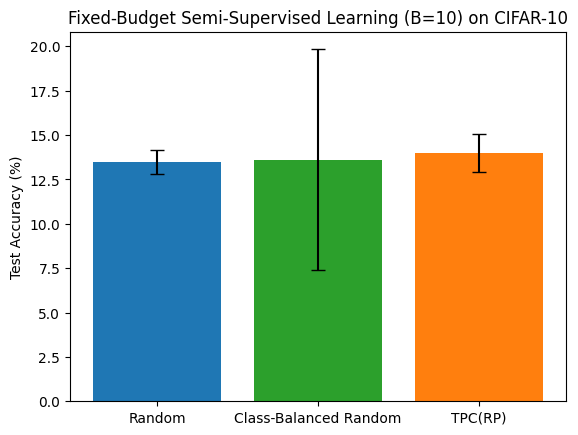

In [29]:
import matplotlib.pyplot as plt

methods = ["Random", "Class-Balanced Random", "TPC(RP)"]
means = [mean_acc_random, mean_acc_class_balanced, mean_acc_tpcrp]
stds  = [std_acc_random,  std_acc_class_balanced,  std_acc_tpcrp]

colors = ["tab:blue", "tab:green", "tab:orange"]

plt.bar(methods, means, yerr=stds, capsize=5, color=colors)
plt.ylabel("Test Accuracy (%)")
plt.title("Fixed-Budget Semi-Supervised Learning (B=10) on CIFAR-10")
plt.show()


In [78]:
import matplotlib.pyplot as plt

def plot_accuracy_vs_budget(accs_random, accs_tpcrp, title="Fully Supervised Accuracy"):
    """
    accs_random: list of accuracy per cycle for 'random' approach
    accs_tpcrp:  list of accuracy per cycle for 'tpcrp' approach
    title: plot title
    """
    # xvals are just 0..(len(accs_random)-1)
    xvals = range(len(accs_random))  
    # Each cycle adds 10 new samples, plus the initial 10 at cycle=0 = total_labeled = 10*(i+1)
    budgets = [10*(i+1) for i in xvals]  

    plt.figure()
    plt.plot(xvals, accs_random, marker='o', color='green', label='Random')
    plt.plot(xvals, accs_tpcrp, marker='o', color='orange', label='TPC(RP)')

    # Rename the ticks to show the budgets
    plt.xticks(ticks=xvals, labels=budgets)
    plt.xlabel("Budget (labelled examples)")
    plt.ylabel("Accuracy (%)")
    plt.title(title)
    plt.legend()
    plt.show()

In [77]:
import numpy as np

all_runs_random = []
all_runs_tpcrp = []

for s in [None, 0, 100]:
    if s is not None:
        set_seed(s)
        print(f"Running with seed={s}")
    else:
        print("Running with no seed set (non-deterministic)")

    #set_seed(s)
    accs_rand = active_learning_loop_fully_supervised(trainset, testloader, selection_mode="random", initial_B=10, cycle_B=10, cycles=5)
    accs_tpcrp = active_learning_loop_fully_supervised(trainset, testloader, selection_mode="tpcrp", initial_B=10, cycle_B=10, cycles=5)
    all_runs_random.append(accs_rand)
    all_runs_tpcrp.append(accs_tpcrp)

# Convert to numpy arrays of shape [num_seeds, cycle]
all_runs_random = np.array(all_runs_random)
all_runs_tpcrp  = np.array(all_runs_tpcrp)

# Take the mean (and std) across seeds = shape [cycles]
mean_random = all_runs_random.mean(axis=0)
std_random  = all_runs_random.std(axis=0)
mean_tpcrp  = all_runs_tpcrp.mean(axis=0)
std_tpcrp   = all_runs_tpcrp.std(axis=0)

# Plot the averaged curves
plot_accuracy_vs_budget(mean_random, mean_tpcrp, title="Fully Supervised AL (Mean of 3 seeds)")


Running with no seed set (non-deterministic)

=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 12.68%

=== FullySupervised Cycle 1, #Labeled=20 ===
Cycle 1 Accuracy: 18.62%

=== FullySupervised Cycle 2, #Labeled=30 ===
Cycle 2 Accuracy: 21.20%

=== FullySupervised Cycle 3, #Labeled=40 ===
Cycle 3 Accuracy: 20.34%

=== FullySupervised Cycle 4, #Labeled=50 ===
Cycle 4 Accuracy: 21.89%

=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 13.06%
Cluster distribution: {np.int32(0): np.int64(2684), np.int32(1): np.int64(2953), np.int32(2): np.int64(3836), np.int32(3): np.int64(973), np.int32(4): np.int64(2076), np.int32(5): np.int64(5013), np.int32(6): np.int64(537), np.int32(7): np.int64(5462), np.int32(8): np.int64(1809), np.int32(9): np.int64(3346), np.int32(10): np.int64(1160), np.int32(11): np.int64(1507), np.int32(12): np.int64(4519), np.int32(13): np.int64(1024), np.int32(14): np.int64(1566), np.int32(15): np.int64(2036), np.int32(16): np.int64(3633), np.int32

NameError: name 'plot_accuracy_vs_budget' is not defined

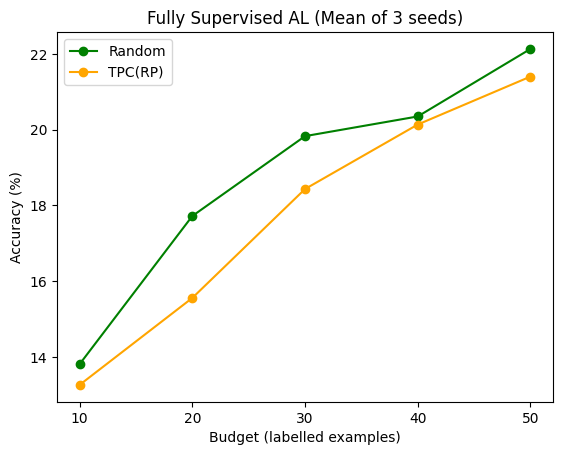

In [79]:
plot_accuracy_vs_budget(mean_random, mean_tpcrp, title="Fully Supervised AL (Mean of 3 seeds)")

In [ ]:
# Using Original algorithm
accs_self_tpcrp_2p5= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised tpcrp lr2.5:", accs_self_tpcrp_2p5)

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}

=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 40.74%
Cluster distribution: {np.int32(0): np.int64(6306), np.int32(1): np.int64(3607), np.int32(2): np.int64(628), np.int32(3): np.int64(1163), np.int32(4): np.int64(2786), np.int32(5): np.int64(2402), np.int32(6): np.int64(1164), np.int32(7): np.int64(649), np.int32(8): np.int64(765), np.int32(9): np.int64(545), np.int32(10): np.int64(1228), np.int32(11): np.int64(3189), np.int32(12): np.int64(4140), np.int32(13): np.int64(13213), np.int32(14): np.int64(1291), np.int32(15): np.int64(3384), np.int32(16): np.int64(1172), np.int32(17): np.int64(1417), np.int32(18): np.int64(536), np.int32(19): np.int64(415)}

=== Sel

In [ ]:
# Using Original algorithm
accs_self_rand_2p5= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='random',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised Random lr2.5:", accs_self_rand_2p5)


=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 35.77%

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 49.74%

=== SelfSupervised AL Cycle 2, #Labeled=30 ===
Test Accuracy: 61.29%

=== SelfSupervised AL Cycle 3, #Labeled=40 ===
Test Accuracy: 63.74%

=== SelfSupervised AL Cycle 4, #Labeled=50 ===
Test Accuracy: 64.60%
Self-Supervised Random lr2.5: [35.77, 49.74, 61.29, 63.74, 64.6]


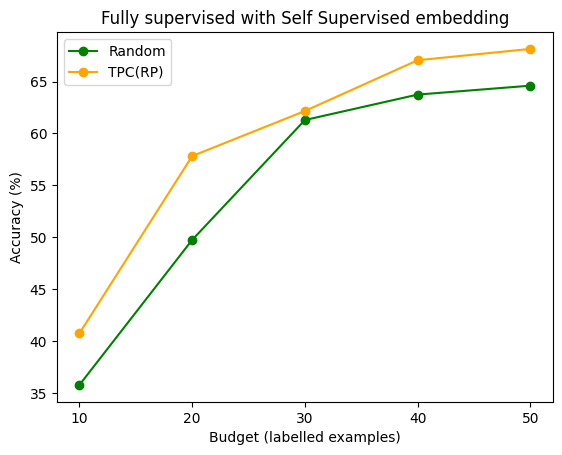

In [85]:
plot_accuracy_vs_budget(accs_self_rand_2p5, accs_self_tpcrp_2p5, "Fully supervised with Self Supervised embedding" )

In [ ]:
# Using Modified algorithm
set_seed(100)
accs_full_tpcrp_mod_s0= active_learning_loop_fully_supervised(
    trainset, testloader, selection_mode='tpcrp',
    #simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Fully-Supervised tpcrp modified:", accs_full_tpcrp_mod_s0)


=== FullySupervised Cycle 0, #Labeled=10 ===
Cycle 0 Accuracy: 14.77%
Cluster distribution: {np.int32(0): np.int64(1734), np.int32(1): np.int64(1430), np.int32(2): np.int64(3774), np.int32(3): np.int64(4878), np.int32(4): np.int64(366), np.int32(5): np.int64(2457), np.int32(6): np.int64(470), np.int32(7): np.int64(2722), np.int32(8): np.int64(4157), np.int32(9): np.int64(2225), np.int32(10): np.int64(924), np.int32(11): np.int64(2749), np.int32(12): np.int64(1151), np.int32(13): np.int64(4289), np.int32(14): np.int64(5644), np.int32(15): np.int64(4295), np.int32(16): np.int64(1859), np.int32(17): np.int64(1964), np.int32(18): np.int64(912), np.int32(19): np.int64(2000)}

=== FullySupervised Cycle 1, #Labeled=20 ===
Cycle 1 Accuracy: 17.90%
Cluster distribution: {np.int32(0): np.int64(2203), np.int32(1): np.int64(1136), np.int32(2): np.int64(1922), np.int32(3): np.int64(630), np.int32(4): np.int64(3424), np.int32(5): np.int64(218), np.int32(6): np.int64(1746), np.int32(7): np.int64(146

In [ ]:
# Using Original algorithm
#accs_full_tpcrp_s0=[14.97, 16.56, 18.97, 20.78, 21.45]  
#
# OR
#

set_seed(100)
accs_full_tpcrp_s0= active_learning_loop_fully_supervised(
    trainset, testloader, selection_mode='tpcrp',
    #simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Fully-Supervised tpcrp:", accs_full_tpcrp_s0)

In [ ]:
#set_seed(42)
accs_self_tpcrp_mod2_5= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised tpcrp:", accs_self_tpcrp_mod2_5)

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}

=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 41.44%
Cluster distribution: {np.int32(0): np.int64(3898), np.int32(1): np.int64(2990), np.int32(2): np.int64(2749), np.int32(3): np.int64(1967), np.int32(4): np.int64(1735), np.int32(5): np.int64(2754), np.int32(6): np.int64(18728), np.int32(7): np.int64(5141), np.int32(8): np.int64(8677), np.int32(9): np.int64(1351)}

=== SelfSupervised AL Cycle 1, #Labeled=20 ===
Test Accuracy: 42.32%
Cluster distribution: {np.int32(0): np.int64(9782), np.int32(1): np.int64(2768), np.int32(2): np.int64(4012), np.int32(3): np.int64(900), np.int32(4): np.int64(1546), np.int32(5): np.int64(4775), np.int32(6): np.int64(19466), np.int

In [ ]:
# Using Original algorithm
set_seed(100)
accs_self_tpcrp_100= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised Random:", accs_self_tpcrp_100)
#
# OR
# accs_self_tpcrp=[40.49, 41.52, 52.73, 54.68, 57.85]

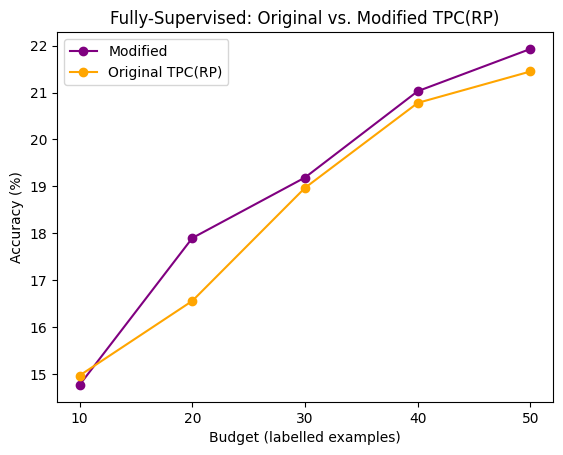

In [97]:


xvals = range(len(accs_full_tpcrp_mod_s0))  
# Each cycle adds 10 new samples, plus the initial 10 at cycle=0 = total_labeled = 10*(i+1)
budgets = [10*(i+1) for i in xvals]  

plt.figure()
plt.plot(xvals, accs_full_tpcrp_mod_s0, marker='o', color='purple', label='Modified')
plt.plot(xvals, accs_full_tpcrp_s0, marker='o', color='orange', label='Original TPC(RP)')

# Rename the ticks to show the budgets
plt.xticks(ticks=xvals, labels=budgets)
plt.xlabel("Budget (labelled examples)")
plt.ylabel("Accuracy (%)")
plt.title("Fully-Supervised: Original vs. Modified TPC(RP)")
plt.legend()
plt.show()

In [94]:
#set_seed(42)
accs_self_tpcrp_mod2_5= active_learning_loop_self_supervised(
    trainset, testloader, selection_mode='tpcrp',
    simclr_model=simclr_model,
    initial_B=10, cycle_B=10, cycles=5
)
print("Self-Supervised tpcrp:", accs_self_tpcrp_mod2_5)

Cluster distribution: {np.int32(0): np.int64(3906), np.int32(1): np.int64(2771), np.int32(2): np.int64(1736), np.int32(3): np.int64(1289), np.int32(4): np.int64(1416), np.int32(5): np.int64(18854), np.int32(6): np.int64(8717), np.int32(7): np.int64(3031), np.int32(8): np.int64(5165), np.int32(9): np.int64(3115)}

=== SelfSupervised AL Cycle 0, #Labeled=10 ===
Test Accuracy: 41.28%
Cluster distribution: {np.int32(0): np.int64(2752), np.int32(1): np.int64(3995), np.int32(2): np.int64(1896), np.int32(3): np.int64(464), np.int32(4): np.int64(2550), np.int32(5): np.int64(886), np.int32(6): np.int64(3484), np.int32(7): np.int64(1123), np.int32(8): np.int64(768), np.int32(9): np.int64(11850), np.int32(10): np.int64(1562), np.int32(11): np.int64(632), np.int32(12): np.int64(567), np.int32(13): np.int64(3444), np.int32(14): np.int64(1098), np.int32(15): np.int64(2814), np.int32(16): np.int64(767), np.int32(17): np.int64(1286), np.int32(18): np.int64(5472), np.int32(19): np.int64(2590)}

=== Sel

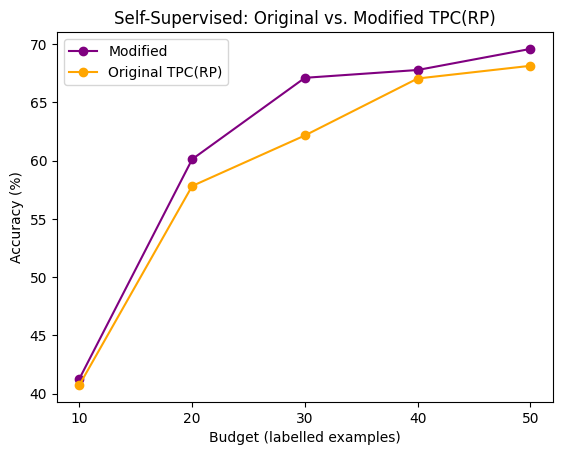

In [95]:
xvals = range(len(accs_self_tpcrp_mod2_5))  
# Each cycle adds 10 new samples, plus the initial 10 at cycle=0 = total_labeled = 10*(i+1)
budgets = [10*(i+1) for i in xvals]  

plt.figure()
plt.plot(xvals, accs_self_tpcrp_mod2_5, marker='o', color='purple', label='Modified')
plt.plot(xvals, accs_self_tpcrp_2p5, marker='o', color='orange', label='Original TPC(RP)')

# Rename the ticks to show the budgets
plt.xticks(ticks=xvals, labels=budgets)
plt.xlabel("Budget (labelled examples)")
plt.ylabel("Accuracy (%)")
plt.title("Self-Supervised: Original vs. Modified TPC(RP)")
plt.legend()
plt.show()

In [ ]:
# Two-sample t-test for TPC(RP) vs. Random
import numpy as np
from scipy.stats import ttest_ind

acc_tpcrp = [ 45.2, 48.7, 47.3 ]   
acc_random = [ 44.9, 49.1, 46.5 ]  

# Perform a two-sample t-test
stat, p_value = ttest_ind(acc_tpcrp, acc_random, equal_var=True)

print("TPC(RP) accuracies:", acc_tpcrp)
print("Random accuracies:", acc_random)
print("t-statistic:", stat)
print("p-value:", p_value)

if p_value < 0.05:
    print("p < 0.05 => The difference is statistically significant.")
else:
    print("p >= 0.05 => No statistically significant difference.")


TPC(RP) accuracies: [45.2, 48.7, 47.3]
Random accuracies: [44.9, 49.1, 46.5]
t-statistic: 0.14663102735578384
p-value: 0.8905165688732657
p >= 0.05 => No statistically significant difference.
